In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6236586129532527410
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16266690560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1865571087869063454
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, 
    log_loss, precision_recall_fscore_support, roc_curve, auc
)

%matplotlib inline

In [3]:
image_path="/kaggle/input/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry"
os.listdir(image_path)


['tom_jerry_1', 'jerry', 'tom', 'tom_jerry_0']

# define some parameters for the loader

In [4]:
batch_size=32
image_height=252
image_width=252

### It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
                                          image_path,
                                          validation_split=0.2,
                                          subset="training",
                                          seed=123,
                                          image_size=(image_height, image_width),
                                          batch_size=batch_size)

Found 5478 files belonging to 4 classes.
Using 4383 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
                                              image_path,
                                              validation_split=0.2,
                                              subset="validation",
                                              seed=123,
                                              image_size=(image_height, image_width),
                                              batch_size=batch_size)

Found 5478 files belonging to 4 classes.
Using 1095 files for validation.


In [7]:
class_names = train_ds.class_names
num_class=len(class_names)
print(class_names)

['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']


# Compare class length from train data

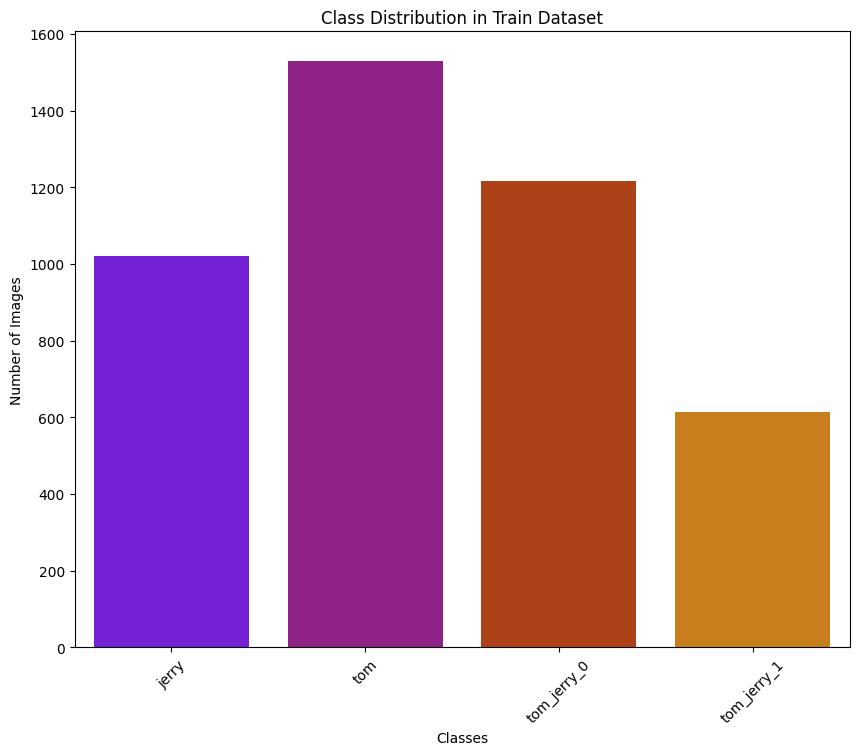

In [8]:
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_ds:
    unique, counts = np.unique(labels.numpy(), return_counts=True)
    for i, count in zip(unique, counts):
        class_counts[class_names[i]] += count

# Convert to DataFrame for Seaborn
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Class', y='Count', data=df, palette="gnuplot")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Train Dataset")
plt.xticks(rotation=45)
plt.show()

# Compare class length from validation data

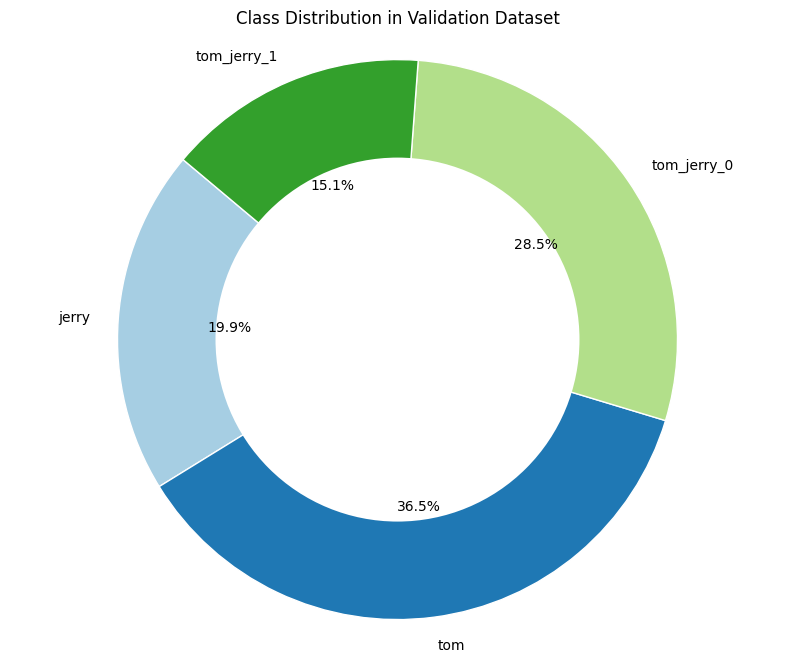

In [9]:
val_class_names = val_ds.class_names
class_counts = {class_name: 0 for class_name in val_class_names}

for images, labels in val_ds:
    unique, counts = np.unique(labels.numpy(), return_counts=True)
    for i, count in zip(unique, counts):
        class_counts[val_class_names[i]] += count

labels = list(class_counts.keys())
sizes = list(class_counts.values())

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=140, wedgeprops={'edgecolor': 'white'})
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
plt.gca().add_patch(centre_circle)

plt.title("Class Distribution in Validation Dataset")
plt.axis('equal')
plt.show()

# Visualize the data
### Here are the first nine images from the training dataset:

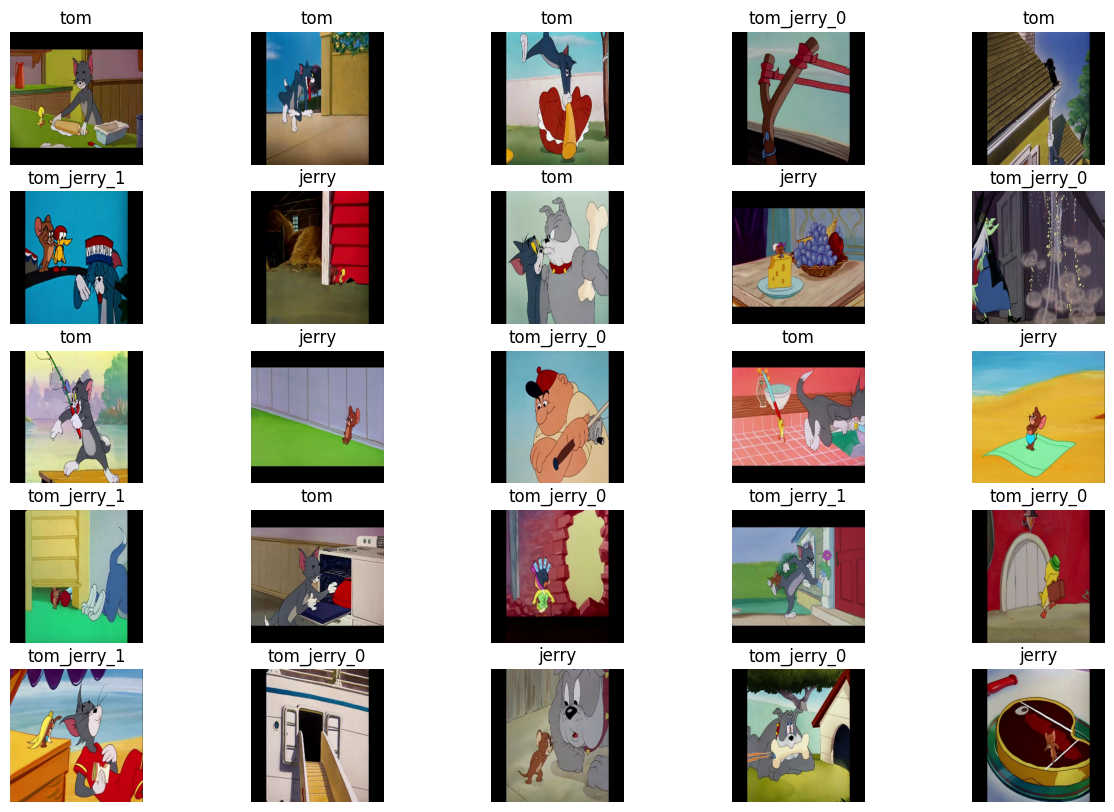

In [10]:

plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

# plot data from validation data

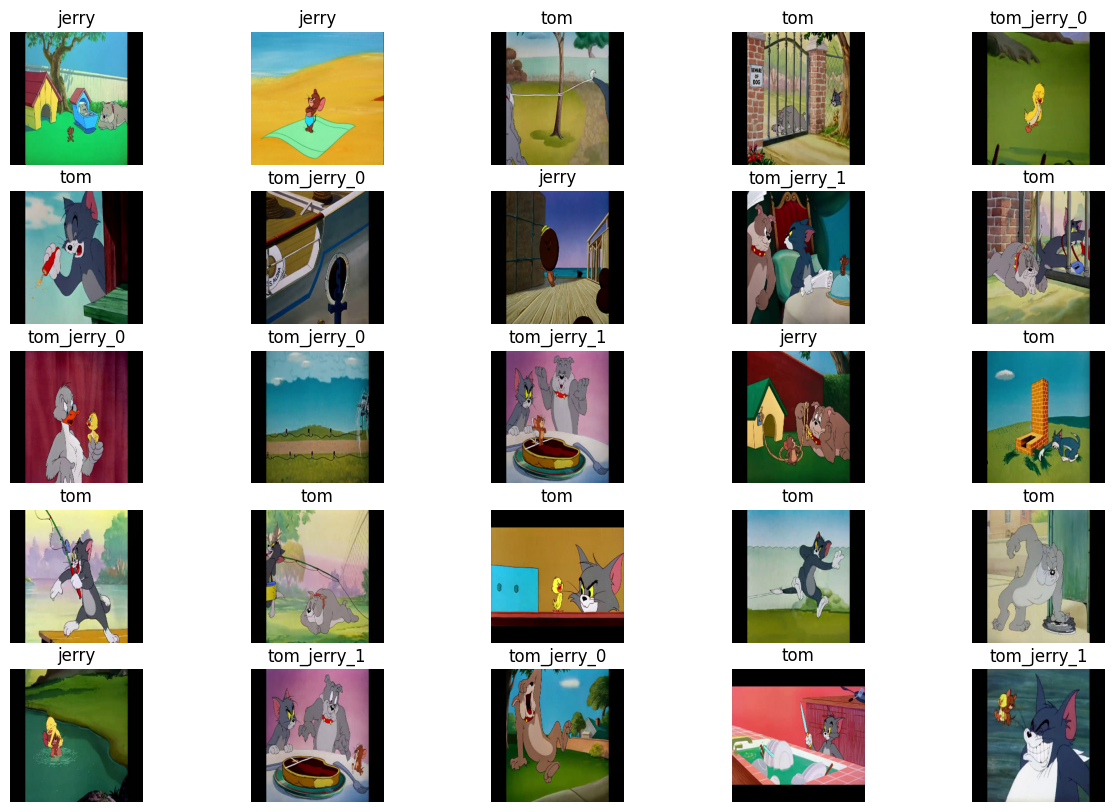

In [11]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 252, 252, 3)
(32,)


# Configure the dataset for performance
* Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* Dataset.prefetch overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data
* The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

* Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)


# Create Model

In [17]:
base_model = tf.keras.applications.Xception(include_top=False,weights="imagenet",
                                            input_shape=(252, 252, 3),pooling="avg")

# Freeze base model layers
base_model.trainable = False

# Create model

model = tf.keras.Sequential([base_model,tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_class, activation="softmax")])

model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

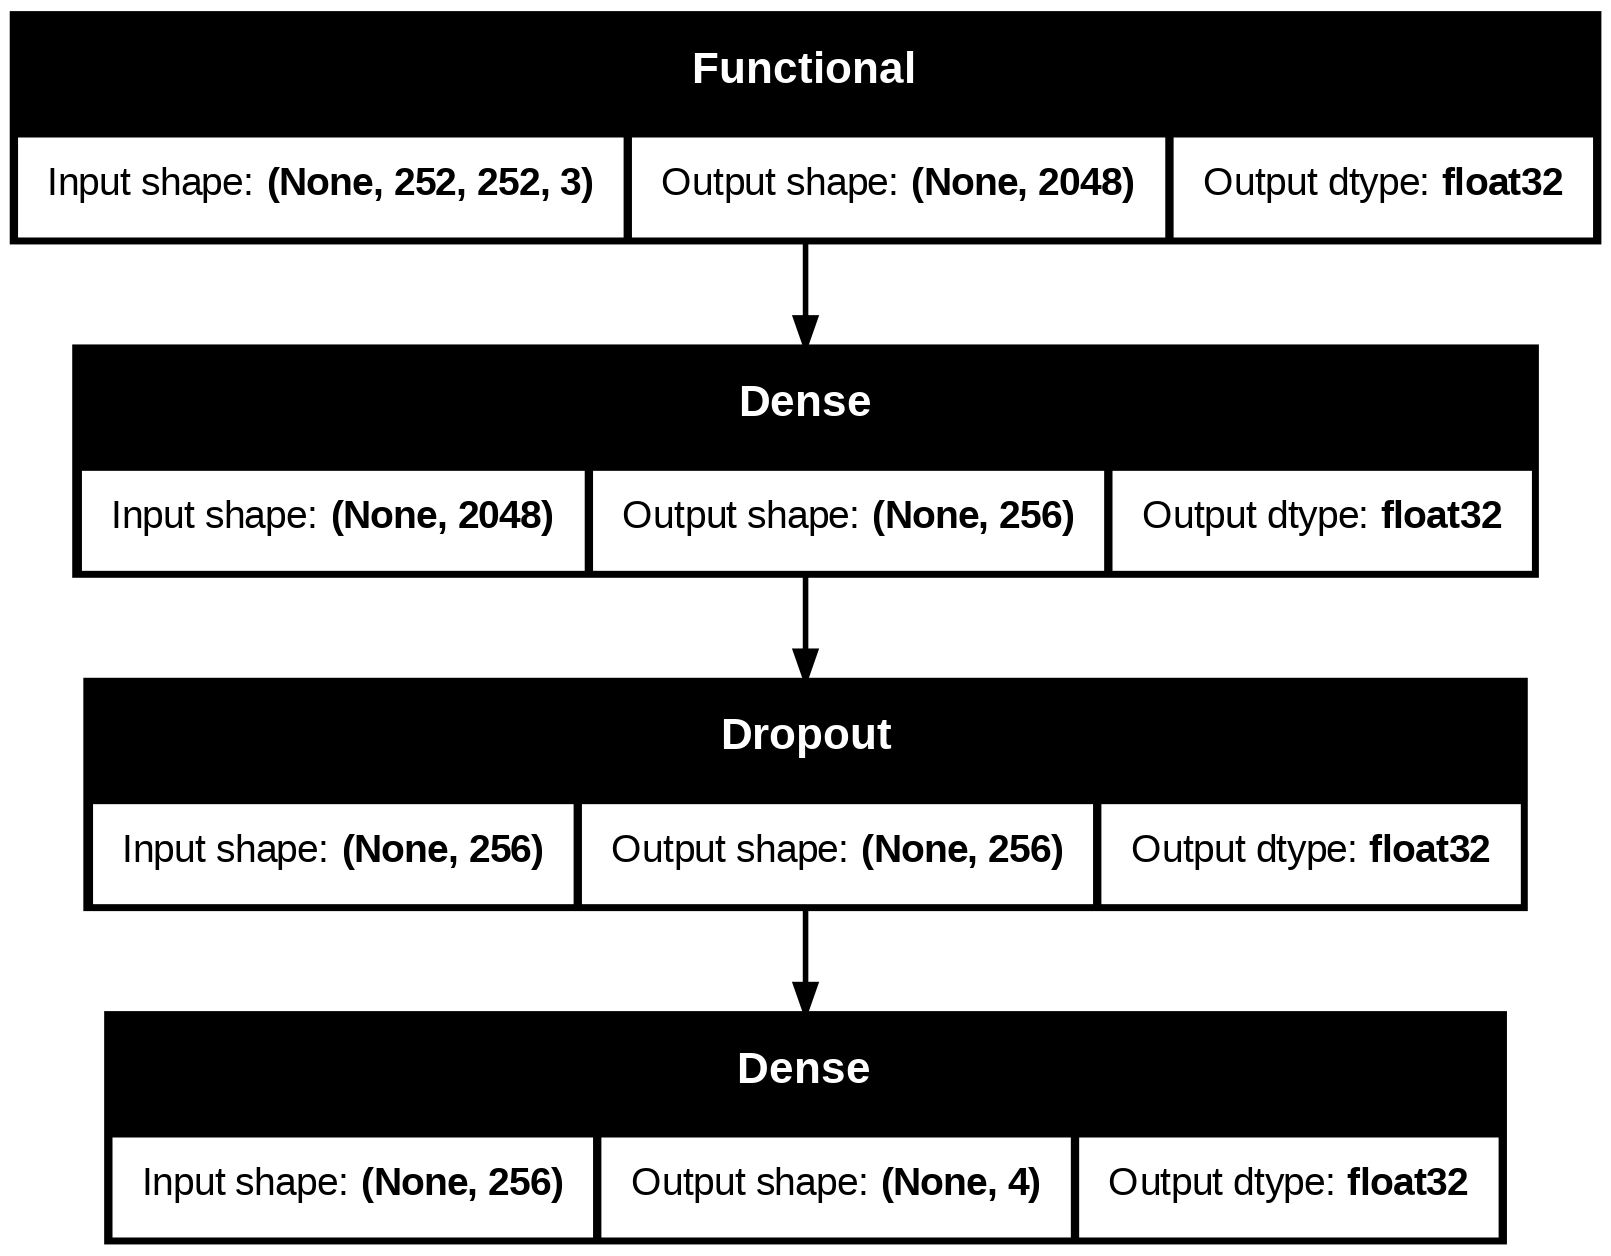

In [18]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True)

In [19]:
epochs=10
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 39s 208ms/step - accuracy: 0.4820 - loss: 1.1871 - val_accuracy: 0.6584 - val_loss: 0.8290
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.6918 - loss: 0.7718 - val_accuracy: 0.7635 - val_loss: 0.6555
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.7829 - loss: 0.5782 - val_accuracy: 0.7324 - val_loss: 0.6746
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8214 - loss: 0.4958 - val_accuracy: 0.7507 - val_loss: 0.6395
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.8553 - loss: 0.3946 - val_accuracy: 0.7973 - val_loss: 0.5644
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.8722 - loss: 0.3485 - val_accuracy: 0.8110 - val_loss: 0.5093
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.8926 - loss: 0.3060 - val_accuracy: 0.8338 - val_loss: 0.4676
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.9112 - loss: 0

# Visualize training results
### Create plots of the loss and accuracy on the training and validation sets:

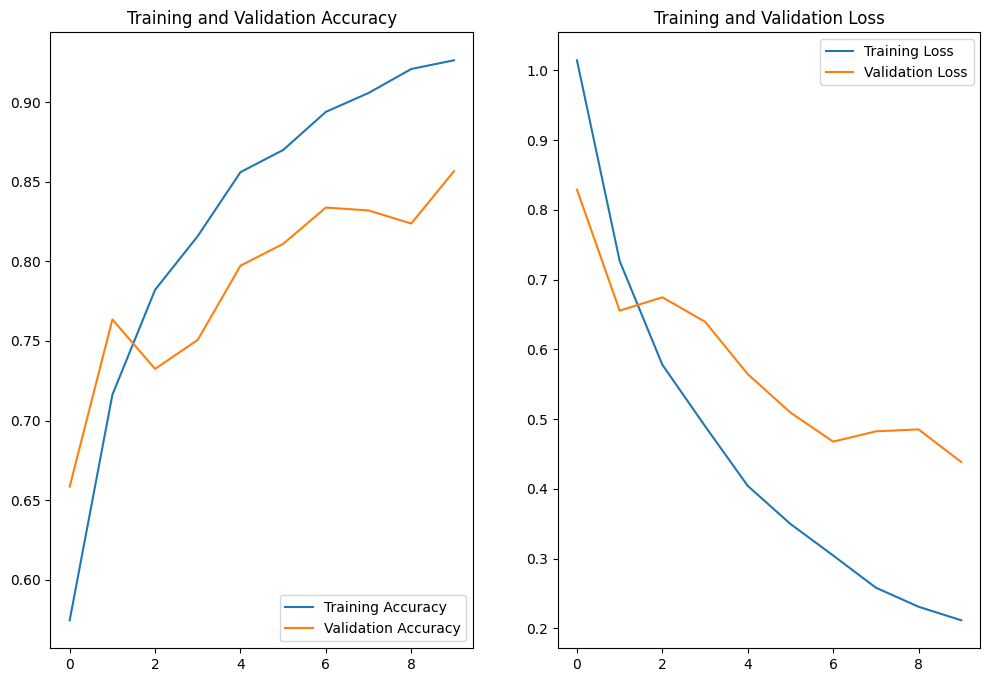

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data augmentation

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


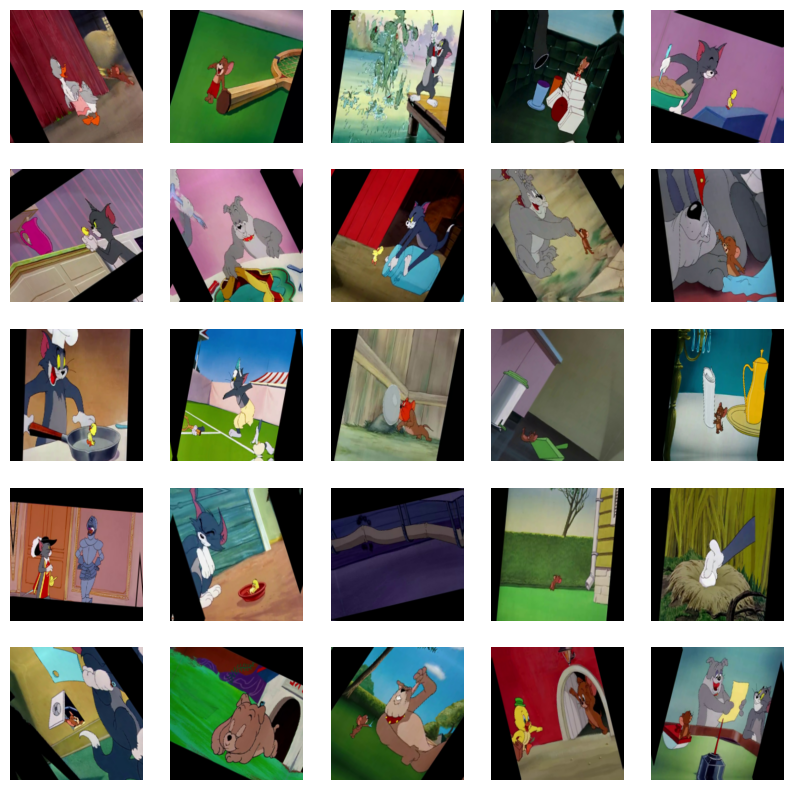

In [22]:


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  augmented_images = data_augmentation(images)  # Apply data augmentation

  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    
    # Ensure images are in the proper format [0, 255] range
    augmented_image = augmented_images[i].numpy().astype("float32")
    augmented_image = np.clip(augmented_image * 255.0, 0, 255).astype("uint8")

    plt.imshow(augmented_image)  # Display the image
    plt.axis("off")  # Hide axes

plt.show()


# Create Model with augmentation

In [23]:

model2 = tf.keras.Sequential([base_model,tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_class, activation="softmax")])

model2.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [24]:
history2 = model2.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 27s 150ms/step - accuracy: 0.5114 - loss: 1.1233 - val_accuracy: 0.7059 - val_loss: 0.7844
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.7170 - loss: 0.7275 - val_accuracy: 0.7580 - val_loss: 0.6363
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.7822 - loss: 0.5763 - val_accuracy: 0.7982 - val_loss: 0.5688
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.8174 - loss: 0.4810 - val_accuracy: 0.7982 - val_loss: 0.5584
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.8546 - loss: 0.4081 - val_accuracy: 0.8192 - val_loss: 0.4907
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.8843 - loss: 0.3402 - val_accuracy: 0.8274 - val_loss: 0.4634
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.9025 - loss: 0.2905 - val_accuracy: 0.8521 - val_loss: 0.4365
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.9152 - loss: 0

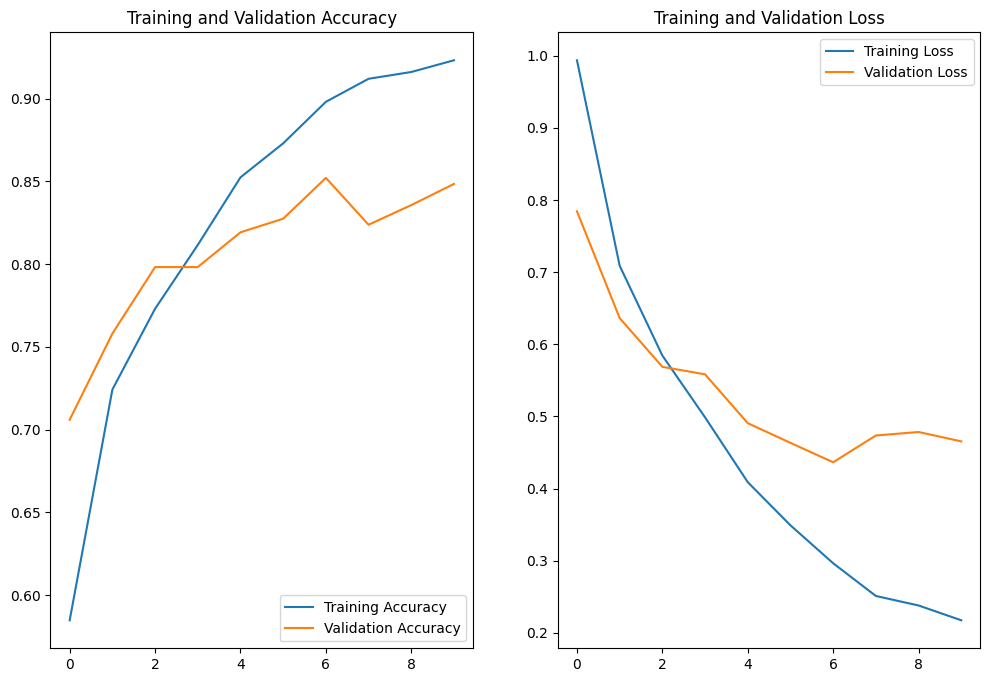

In [25]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on new data

In [26]:


sunflower_path = "/kaggle/input/custom-image-dataset/tom_2.png"
img_height, img_width = 252, 252


img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f"This image most likely belongs to {class_names[np.argmax(score)]} with a {100 * np.max(score):.2f} percent confidence.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image most likely belongs to tom_jerry_1 with a 47.54 percent confidence.


In [27]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmphfdydnu8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 252, 252, 3), dtype=tf.float32, name='keras_tensor_142')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135947523883776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135947514991488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135947514995184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135947514995888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135947514992544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135947514994832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135947498224832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135947514999056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135947515000464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135947515001344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1359475149

# Run the TensorFlow Lite model

In [28]:
TF_MODEL_FILE_PATH = '/kaggle/working/model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

#### Print the signatures from the converted model to obtain the names of the inputs (and outputs):

In [29]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_142'], 'outputs': ['output_0']}}

* In this example, you have one default signature called serving_default. In addition, the name of the 'inputs' is 'sequential_1_input', while the 'outputs' are called 'outputs'. You can look up these first and last Keras layer names when running Model.summary, as demonstrated earlier in this tutorial.

* Now you can test the loaded TensorFlow Model by performing inference on a sample image with tf.lite.Interpreter.get_signature_runner by passing the signature name as follows:

In [30]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

* Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

* You have already tensorized that image and saved it as img_array. Now, pass it to the first argument (the name of the 'inputs') of the loaded TensorFlow Lite model (predictions_lite), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [31]:
predictions_lite = classify_lite(keras_tensor_142=img_array)['output_0']
score_lite = tf.nn.softmax(predictions_lite)

In [32]:
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite)))

This image most likely belongs to tom_jerry_1 with a 47.54 percent confidence.


In [33]:
print(np.max(np.abs(predictions - predictions_lite)))

2.671311e-36


# Confusion Matrix

35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step


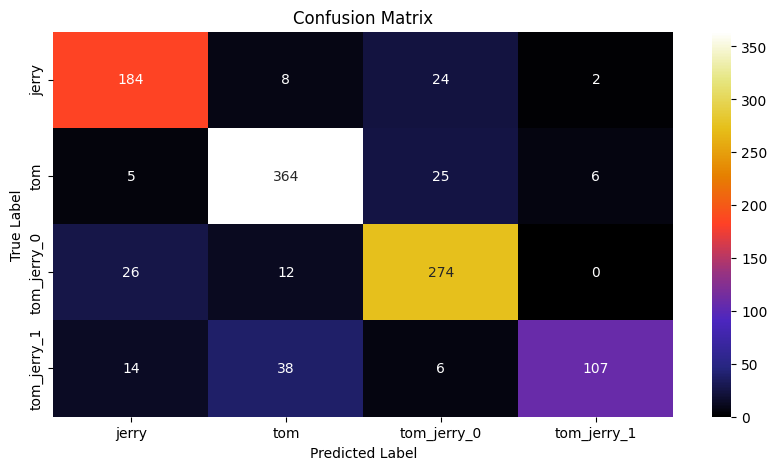

In [34]:
pred=model2.predict(val_ds)
final_pred=np.argmax(pred,axis=1)
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

cm = confusion_matrix(true_labels, final_pred)
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="CMRmap", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [35]:
print(classification_report(true_labels,final_pred,target_names=class_names))

              precision    recall  f1-score   support

       jerry       0.80      0.84      0.82       218
         tom       0.86      0.91      0.89       400
 tom_jerry_0       0.83      0.88      0.85       312
 tom_jerry_1       0.93      0.65      0.76       165

    accuracy                           0.85      1095
   macro avg       0.86      0.82      0.83      1095
weighted avg       0.85      0.85      0.85      1095



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


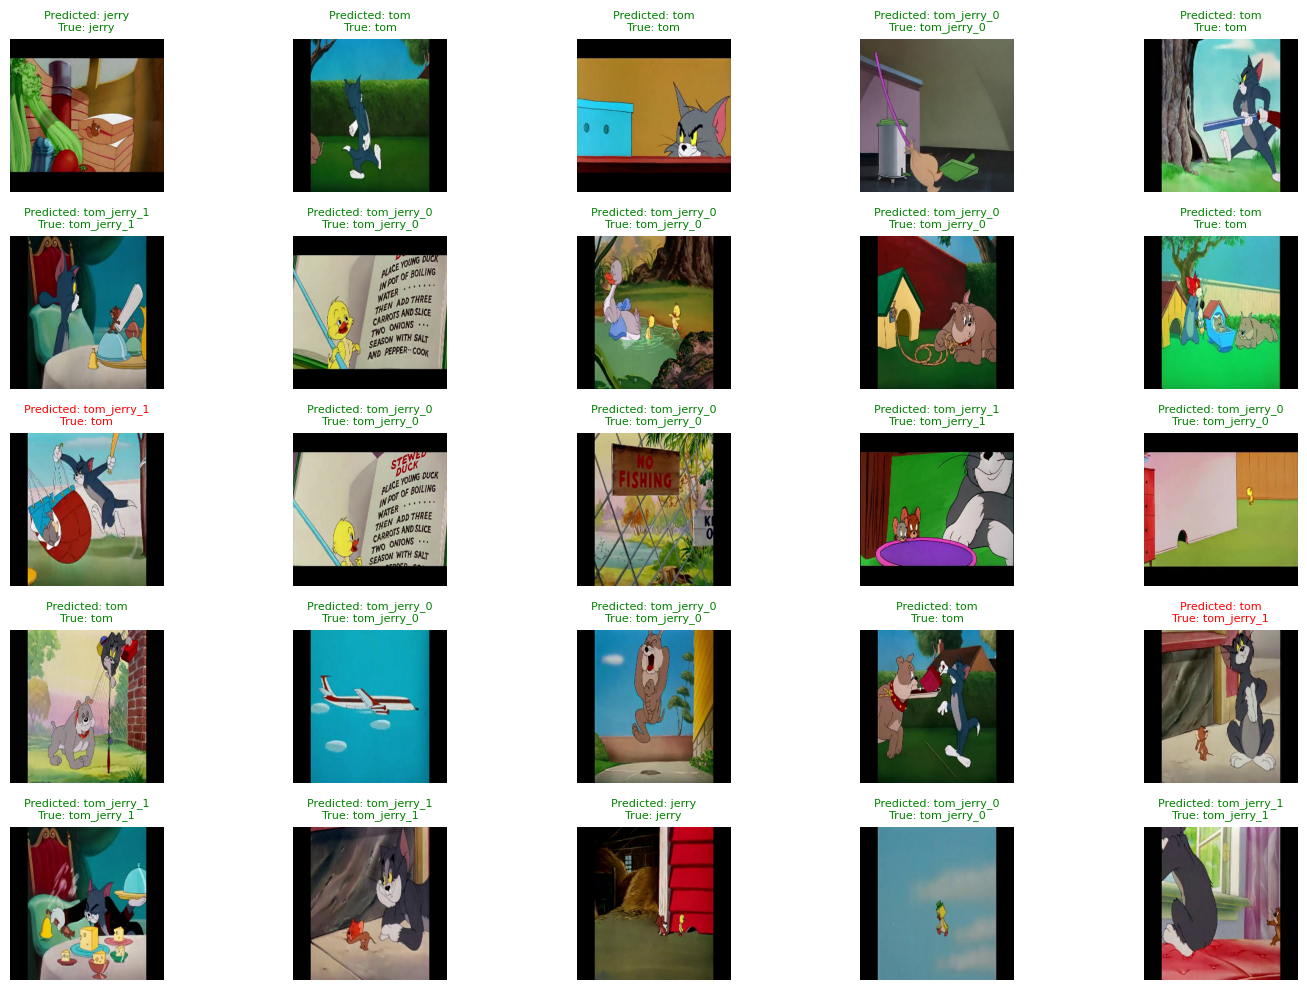

In [36]:

images, true_labels = next(iter(val_ds))
pred = model2.predict(images)
final_pred = np.argmax(pred, axis=1)

plt.figure(figsize=(15, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = images[i].numpy()

    if img.max() <= 1:
        img = (img * 255).astype("uint8")  

    plt.imshow(img)
    color = "green" if final_pred[i] == true_labels[i] else "red"
    title_text = f"Predicted: {class_names[final_pred[i]]}\nTrue: {class_names[true_labels[i]]}"
    plt.title(title_text, color=color, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()
